<a href="https://colab.research.google.com/github/HongJaeKwon/machine-learning/blob/master/CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import urllib.request
import zipfile
import numpy as np
import os
from IPython.display import Image
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [ ]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 50;

<IPython.core.display.Javascript object>

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 1s 0us/step


In [ ]:
train_path = os.path.join(PATH, 'train')
validation_path = os.path.join(PATH, 'validation')

In [ ]:
original_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
training_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
original_generator = original_datagen.flow_from_directory(train_path, 
                                                          batch_size=128, 
                                                          target_size=(150, 150), 
                                                          class_mode='binary'
                                                         )

Found 2000 images belonging to 2 classes.


In [ ]:
training_generator = training_datagen.flow_from_directory(train_path, 
                                                          batch_size=128, 
                                                          shuffle=True,
                                                          target_size=(150, 150), 
                                                          class_mode='binary'
                                                         )

Found 2000 images belonging to 2 classes.


In [ ]:
validation_generator = training_datagen.flow_from_directory(validation_path, 
                                                            batch_size=128, 
                                                            shuffle=True,
                                                            target_size=(150, 150), 
                                                            class_mode='binary'
                                                           )

Found 1000 images belonging to 2 classes.


In [ ]:
class_map = {
    0: 'Cats',
    1: 'Dogs', 
}

오리지널 사진 파일
(128, 150, 150, 3) (128,)
0.0


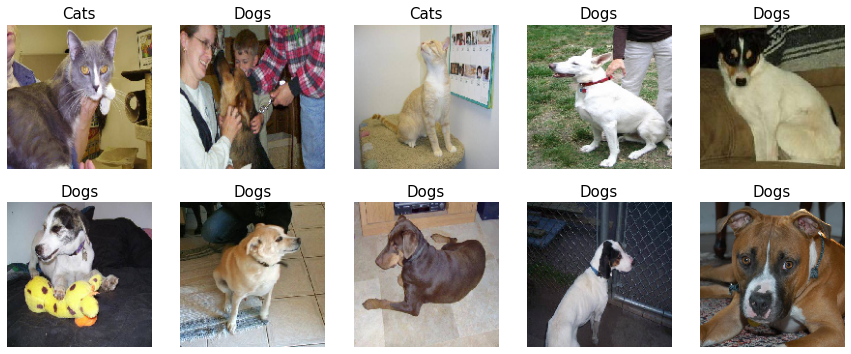

Augmentation 적용한 사진 파일
(128, 150, 150, 3) (128,)
1.0


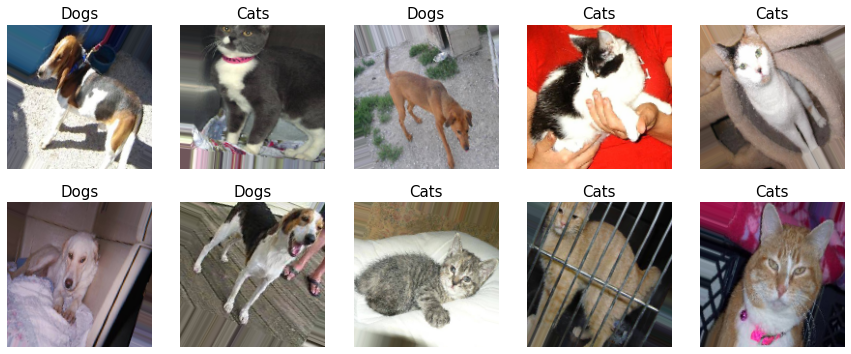

In [ ]:
print('오리지널 사진 파일')

for x, y in original_generator:
    print(x.shape, y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 6)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(class_map[int(y[i])], fontsize=15)
        axes[i//5, i%5].axis('off')
    plt.show()
    break
    
print('Augmentation 적용한 사진 파일')
    
for x, y in training_generator:
    print(x.shape, y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 6)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(class_map[int(y[i])], fontsize=15)
        axes[i//5, i%5].axis('off')
    
    plt.show()
    break

In [ ]:
vgg_model=tf.keras.applications.VGG16(input_shape=(150,150,3),include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


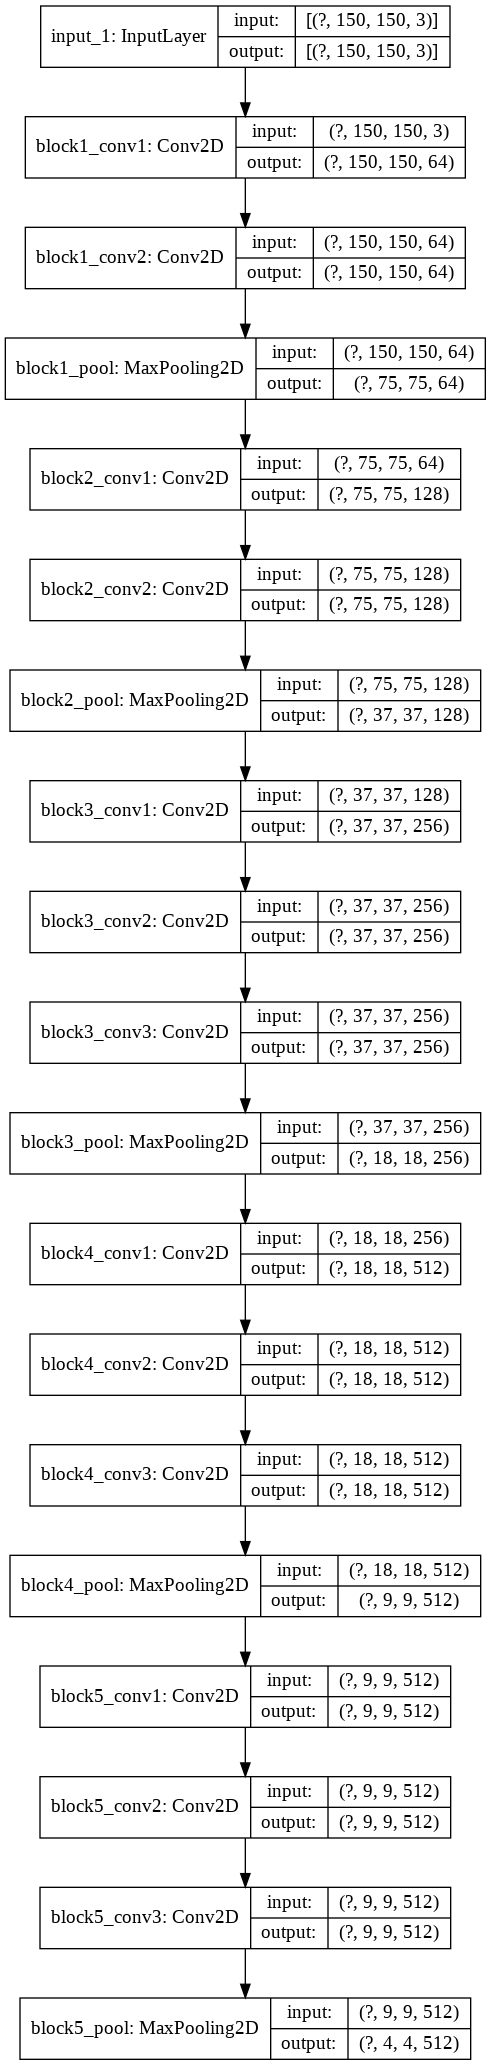

In [ ]:
tf.keras.utils.plot_model(vgg_model,show_shapes=True)

In [ ]:
vgg_model.trainable=False

In [ ]:
i=vgg_model.input
out=vgg_model.get_layer(index=-2).output
out=tf.keras.layers.GlobalAveragePooling2D()(out)
out=tf.keras.layers.Dense(2, activation='softmax')(out)
train_cam_model=tf.keras.Model(inputs=[i],outputs=[out])

In [ ]:
train_cam_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_cam_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
epochs=20

In [ ]:
history = train_cam_model.fit(training_generator, 
                    validation_data=(validation_generator),
                    steps_per_epoch=len(training_generator),
                    validation_steps=len(validation_generator),
                    epochs=epochs, 
                    )

Epoch 1/20
16/16 [==============================] - 21s 1s/step - loss: 0.6727 - acc: 0.5845 - val_loss: 0.6606 - val_acc: 0.6030
Epoch 2/20
16/16 [==============================] - 21s 1s/step - loss: 0.6408 - acc: 0.7025 - val_loss: 0.6260 - val_acc: 0.7300
Epoch 3/20
16/16 [==============================] - 21s 1s/step - loss: 0.6156 - acc: 0.7395 - val_loss: 0.5999 - val_acc: 0.7600
Epoch 4/20
16/16 [==============================] - 21s 1s/step - loss: 0.5901 - acc: 0.7695 - val_loss: 0.5802 - val_acc: 0.7700
Epoch 5/20
16/16 [==============================] - 21s 1s/step - loss: 0.5711 - acc: 0.7750 - val_loss: 0.5620 - val_acc: 0.7760
Epoch 6/20
16/16 [==============================] - 21s 1s/step - loss: 0.5524 - acc: 0.7910 - val_loss: 0.5472 - val_acc: 0.7710
Epoch 7/20
16/16 [==============================] - 21s 1s/step - loss: 0.5376 - acc: 0.7880 - val_loss: 0.5356 - val_acc: 0.7890
Epoch 8/20
16/16 [==============================] - 20s 1s/step - loss: 0.5290 - acc: 0.78

In [ ]:
cam_model = tf.keras.models.Model([train_cam_model.input], [train_cam_model.get_layer('block5_conv3').output,train_cam_model.output])

In [ ]:
class_weights = train_cam_model.layers[-1].get_weights()[0]

In [ ]:
class_num=1

In [ ]:
class_weights[:,class_num].shape

(512,)

In [ ]:
img = cv2.imread('aa.jpg')

In [ ]:
img = cv2.resize(img, (150, 150))

In [ ]:
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

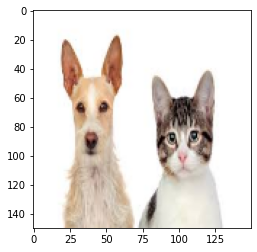

In [ ]:
plt.imshow(img)

In [ ]:
conv_outputs, predictions = cam_model.predict(np.reshape(img,(1,150,150,3)))

In [ ]:
s=[]

In [ ]:
conv_outputs[0].shape

(9, 9, 512)

In [ ]:
class_weights[100,class_num]

0.0656074

In [ ]:
conv_outputs[0][:,:,100]

array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 5.1452355, 0.       , 0.       , 0.       

In [ ]:
class_weights[100,class_num] * conv_outputs[0][:,:,100]

array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.3375655, 0.       , 0.       , 0.       

In [ ]:
i=0
for w in class_weights[:,class_num]:
    s.append(w * conv_outputs[0][:,:,i])
    i=i+1

In [ ]:
s=np.array(s)

In [ ]:
s=np.sum(s,axis=0)

In [ ]:
s.shape

(9, 9)

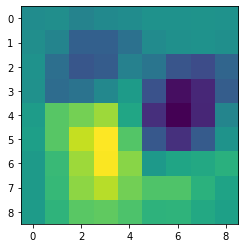

In [ ]:
plt.imshow(s)

In [ ]:
import cv2
cam = cv2.resize(s, (150, 150))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

In [ ]:
heatmap

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.05159856, 0.05159856, 0.05159856, ..., 0.09521208, 0.09521208,
        0.09521208],
       [0.05159856, 0.05159856, 0.05159856, ..., 0.09521208, 0.09521208,
        0.09521208],
       [0.05159856, 0.05159856, 0.05159856, ..., 0.09521208, 0.09521208,
        0.09521208]], dtype=float32)

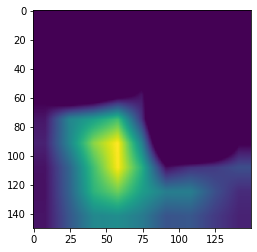

In [ ]:
plt.imshow(heatmap)

In [ ]:
cam = cv2.applyColorMap(np.uint8(255*heatmap),cv2.COLOR_BGR2RGB)

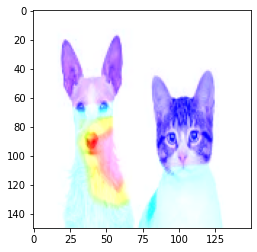

In [ ]:
plt.imshow(cv2.add(cam,img))

In [ ]:
class_num=0
s=[]
i=0
for w in class_weights[:,class_num]:
    s.append(w * conv_outputs[0][:,:,i])
    i=i+1
s=np.array(s)
s=np.sum(s,axis=0)
cam = cv2.resize(s, (150, 150))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())
cam = cv2.applyColorMap(np.uint8(255*heatmap),cv2.COLOR_BGR2RGB)

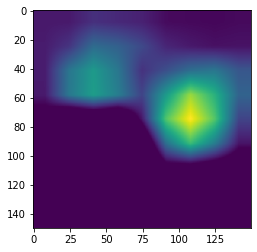

In [ ]:
plt.imshow(heatmap)

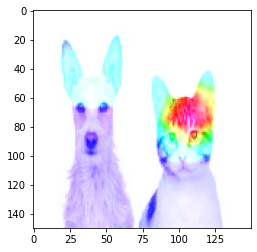

In [ ]:
plt.imshow(cv2.add(cam,img))

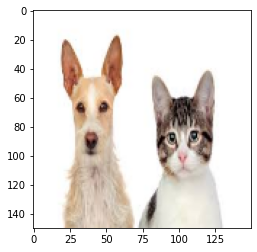

In [ ]:
plt.imshow(img)